In [1]:
# !pip install moviepy

In [2]:
import torch 
import torch.nn.functional as F
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid 
from torch_geometric.transforms import NormalizeFeatures 
from tqdm import tqdm
from sklearn.manifold import TSNE
from moviepy.editor import ImageSequenceClip
from IPython.display import Image

In [3]:
dataset = Planetoid(root='./Data/', name='Cora', transform=NormalizeFeatures())

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
print('Number of graphs: ', len(dataset))
print('Number of features: ', dataset.num_features)
print('Number of classes: ', dataset.num_classes)

data = dataset[0]

print(data)
print('Number of nodes: ', data.num_nodes)
print('Number of edges: ', data.num_edges) 
print('Number of training nodes: ', data.train_mask.sum())
print('Training node label rate: ', int(data.train_mask.sum()) / data.num_nodes)
print('Is undirected', data.is_undirected())

Number of graphs:  1
Number of features:  1433
Number of classes:  7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes:  2708
Number of edges:  10556
Number of training nodes:  tensor(140)
Training node label rate:  0.051698670605613
Is undirected True


In [6]:
print(data.x.shape)
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [7]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [8]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [9]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__() 
        torch.manual_seed(42)
        
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = F.softmax(self.out(x), dim=1)
        return x 
    
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [11]:
model = model.to(device)
data = data.to(device)

learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss 

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

losses = []
for epoch in tqdm(range(2000)):
    loss = train()
    losses.append(loss)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch: {epoch + 1}, Loss: {loss:.4f}')

  5%|███▉                                                                           | 101/2000 [00:11<03:40,  8.62it/s]

Epoch: 100, Loss: 1.8499


 10%|███████▉                                                                       | 201/2000 [00:23<03:40,  8.17it/s]

Epoch: 200, Loss: 1.7532


 15%|███████████▉                                                                   | 301/2000 [00:35<03:57,  7.15it/s]

Epoch: 300, Loss: 1.5565


 20%|███████████████▊                                                               | 401/2000 [00:49<03:18,  8.06it/s]

Epoch: 400, Loss: 1.4302


 25%|███████████████████▊                                                           | 501/2000 [01:01<03:02,  8.23it/s]

Epoch: 500, Loss: 1.3850


 30%|███████████████████████▋                                                       | 601/2000 [01:13<02:44,  8.52it/s]

Epoch: 600, Loss: 1.3730


 35%|███████████████████████████▋                                                   | 701/2000 [01:26<02:36,  8.29it/s]

Epoch: 700, Loss: 1.3820


 40%|███████████████████████████████▋                                               | 801/2000 [01:37<02:20,  8.52it/s]

Epoch: 800, Loss: 1.3417


 45%|███████████████████████████████████▌                                           | 901/2000 [01:49<02:08,  8.54it/s]

Epoch: 900, Loss: 1.3391


 50%|███████████████████████████████████████                                       | 1001/2000 [02:01<01:55,  8.68it/s]

Epoch: 1000, Loss: 1.3824


 55%|██████████████████████████████████████████▉                                   | 1102/2000 [02:13<01:41,  8.82it/s]

Epoch: 1100, Loss: 1.3581


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [02:24<01:34,  8.45it/s]

Epoch: 1200, Loss: 1.3290


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [02:36<01:20,  8.69it/s]

Epoch: 1300, Loss: 1.3421


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [02:48<01:13,  8.10it/s]

Epoch: 1400, Loss: 1.3106


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [03:00<01:03,  7.88it/s]

Epoch: 1500, Loss: 1.3215


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [03:13<00:50,  7.95it/s]

Epoch: 1600, Loss: 1.2995


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [03:26<00:41,  7.27it/s]

Epoch: 1700, Loss: 1.3389


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [03:39<00:27,  7.32it/s]

Epoch: 1800, Loss: 1.2840


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [03:51<00:11,  8.70it/s]

Epoch: 1900, Loss: 1.2896


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:03<00:00,  8.22it/s]

Epoch: 2000, Loss: 1.2780


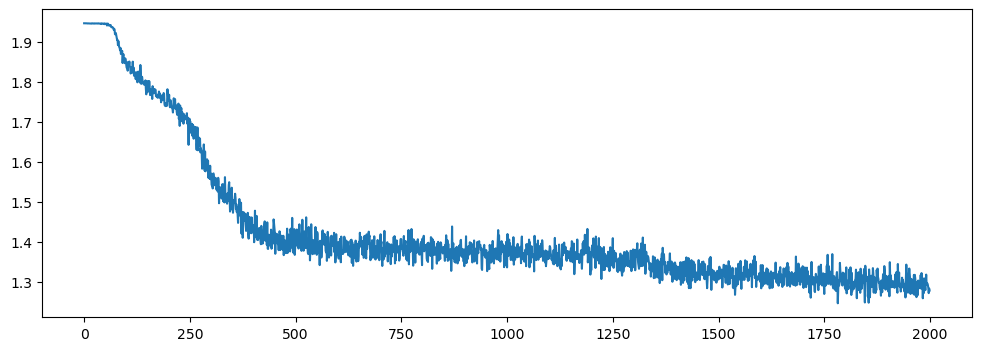

In [12]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
losses_indices = [i for i, l in enumerate(losses_float)]

plt.figure(figsize=(12, 4))
sns.lineplot(x=losses_indices, y=losses_float)
plt.show()

In [13]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7320


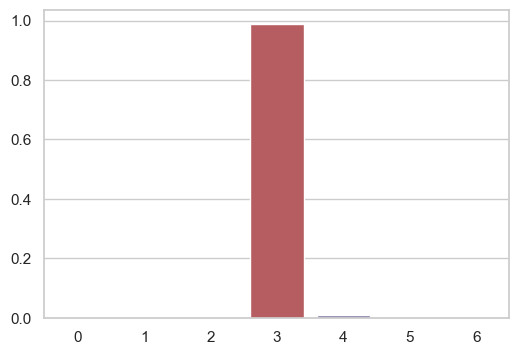

In [14]:
sample = 8 
sns.set_theme(style='whitegrid')
# print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
plt.figure(figsize=(6, 4))
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())
plt.show()

In [15]:
def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w, h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w, h, -1))
    return rgba_arr

def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5, 5), frameon=False)
    fig.suptitle(f'Epoch = {epoch + 1}')
    
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color.detach().cpu().numpy(), cmap='Set2')
    fig.canvas.draw()
    
    return plt2arr(fig)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:15<00:00,  4.59it/s]

TSNE Visualization finished


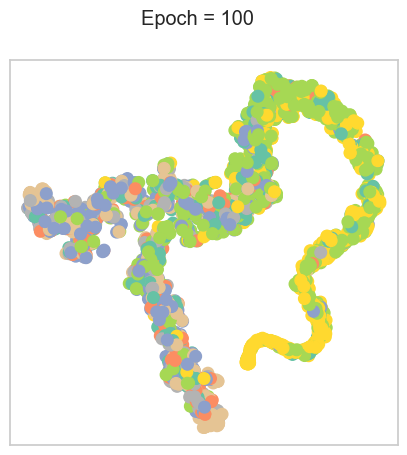

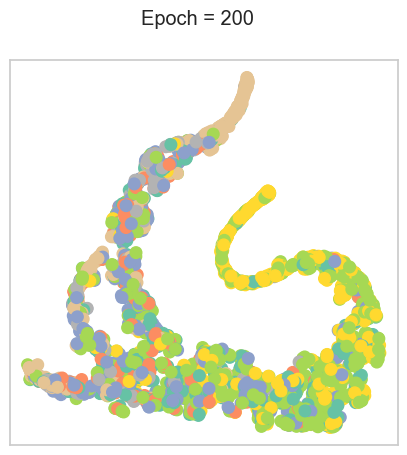

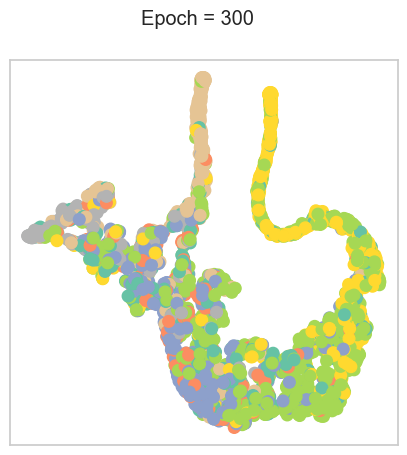

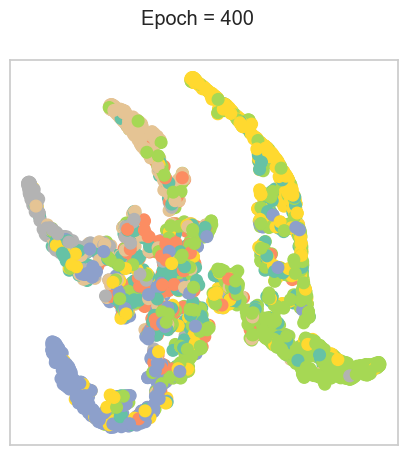

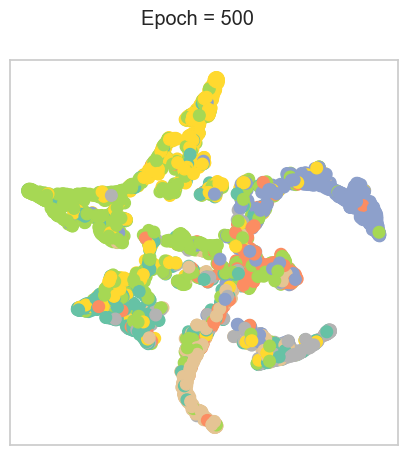

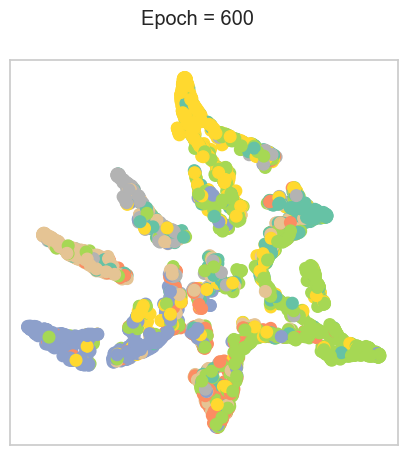

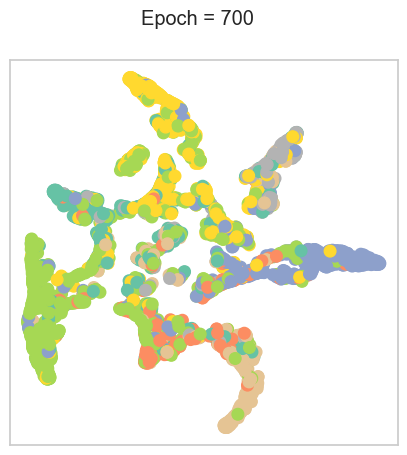

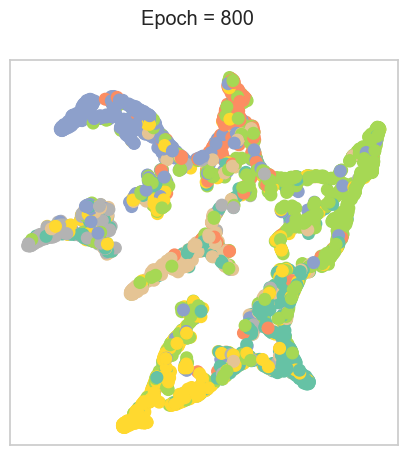

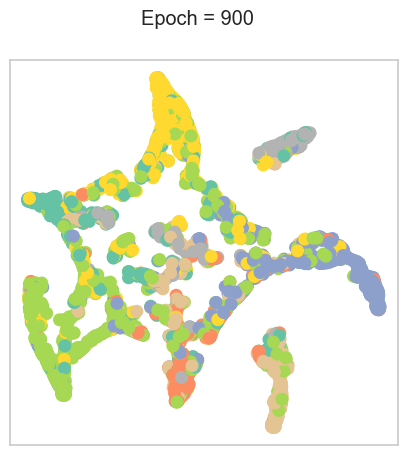

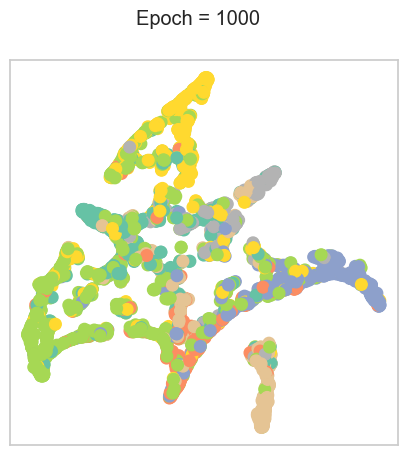

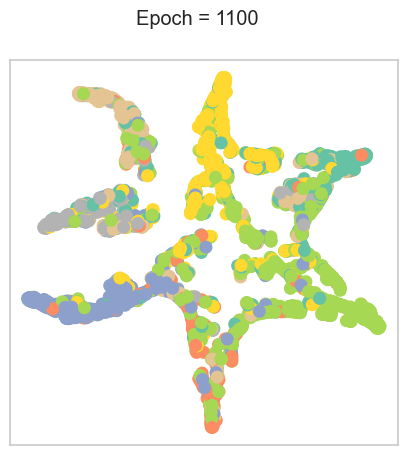

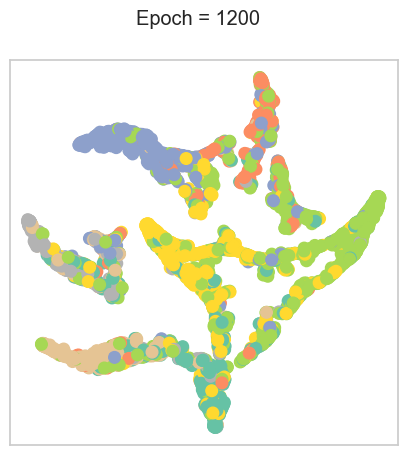

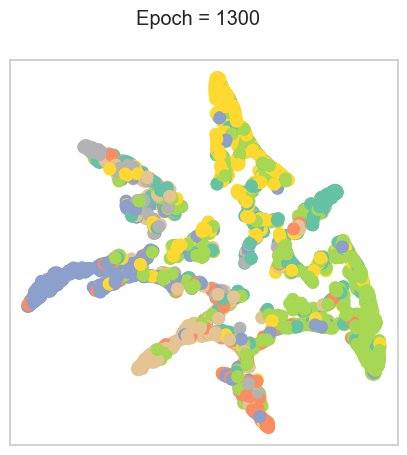

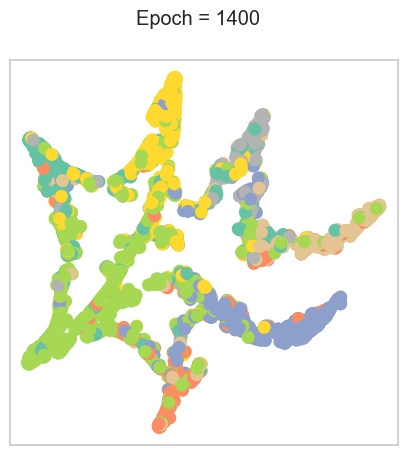

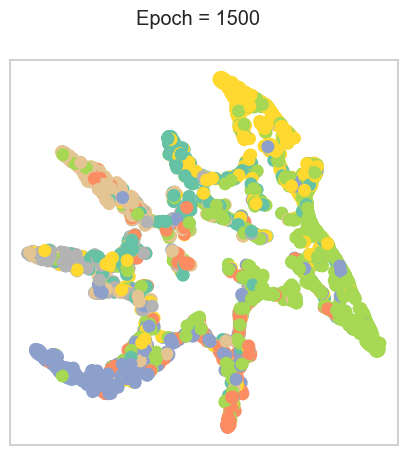

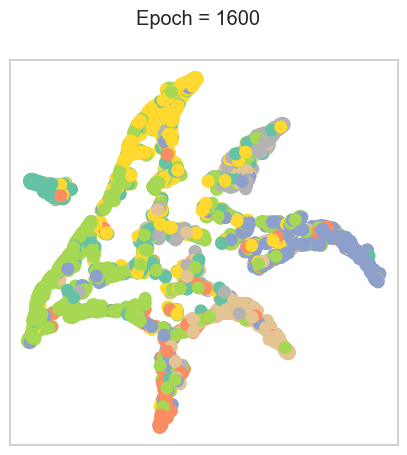

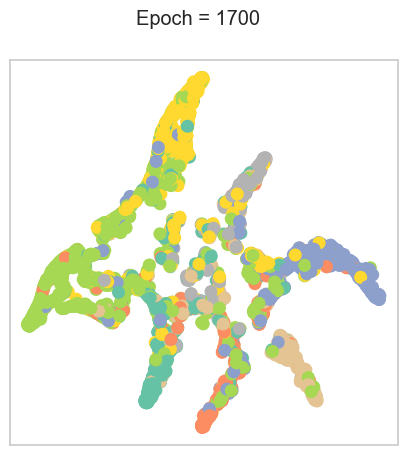

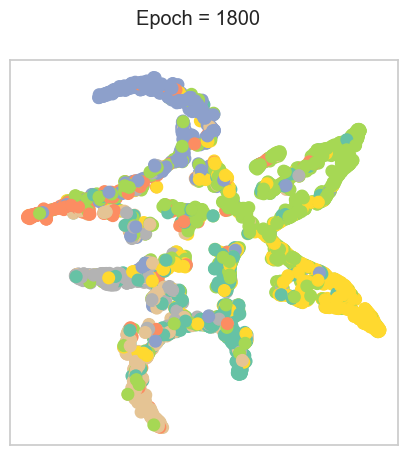

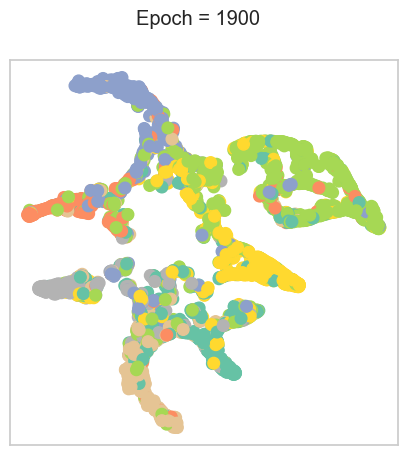

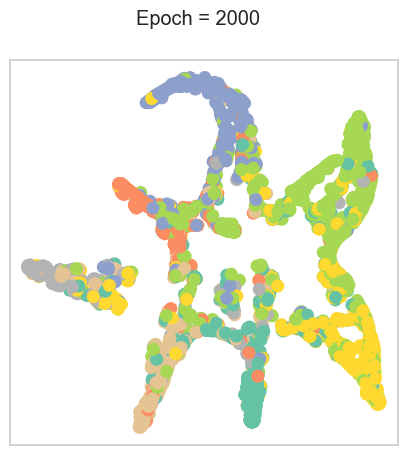

In [16]:
images = []
for epoch in tqdm(range(2000)):
    loss = train()
    if (epoch + 1) % 100 == 0:
        out = model(data.x, data.edge_index)
        images.append(visualize(out, color=data.y, epoch=epoch))
print('TSNE Visualization finished')

MoviePy - Building file ./Cora.gif with imageio.


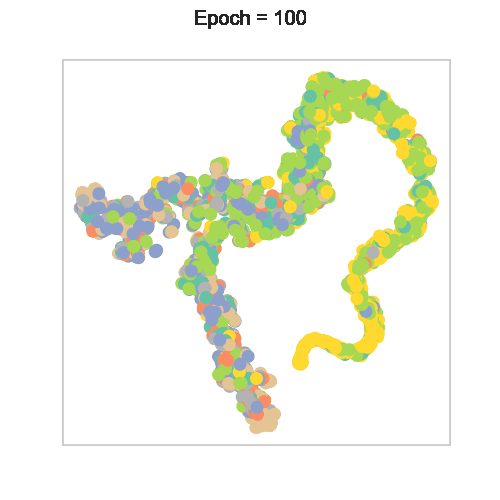

In [17]:
fps = 2
filename = './Cora.gif'
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

with open(filename, 'rb') as f:
    display(Image(data=f.read(), format='png'))